In [81]:
import torch
import torch.nn as nn
import pandas
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from statistics import mean
import numpy as np
from tqdm.notebook import tqdm


In [82]:
torch.manual_seed(123)
torch.set_default_dtype(torch.double)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)


cuda


# Project 2

igu011 and edj001

## Object localization

### Task 2.1

Load the 3 localization datasets localization XXX.pt. There is at most one digit per image.
All digits are represented (C = 10)

In [83]:
localization_train = torch.load("./data/localization_train.pt")
localization_test = torch.load("./data/localization_test.pt")
localization_val = torch.load("./data/localization_val.pt")


First let us take a look at the data and its labels

In [84]:
def to_lower_xy(input):
    scale_w = 60
    scale_h = 48
    x = input[1] * scale_w
    y = input[2] * scale_h
    w = input[3] * scale_w
    h = input[4] * scale_h

    lower_x = x - w / 2
    lower_y = y - h / 2

    return lower_x, lower_y, w, h


def plot_data(data, title):

    COL = 5
    ROW = 2
    fig = plt.figure(figsize=(10, 4), dpi=500)

    for index in range(1, COL * ROW + 1):
        plt.subplot(ROW, COL, index)
        plt.axis("off")
        plt.imshow(data.tensors[0][index][0], cmap="gray_r")
        plt.title(f"y_true: {int(data.tensors[1][index][5])}", fontsize=7)
        x, y, w, h = to_lower_xy(data.tensors[1][index])
        rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="g", facecolor="none")
        ax = plt.gca()
        ax.add_patch(rect)
        ax.legend(
            ["y_true"],
            fontsize=4,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            ncol=1,
        )
    fig.suptitle(title)


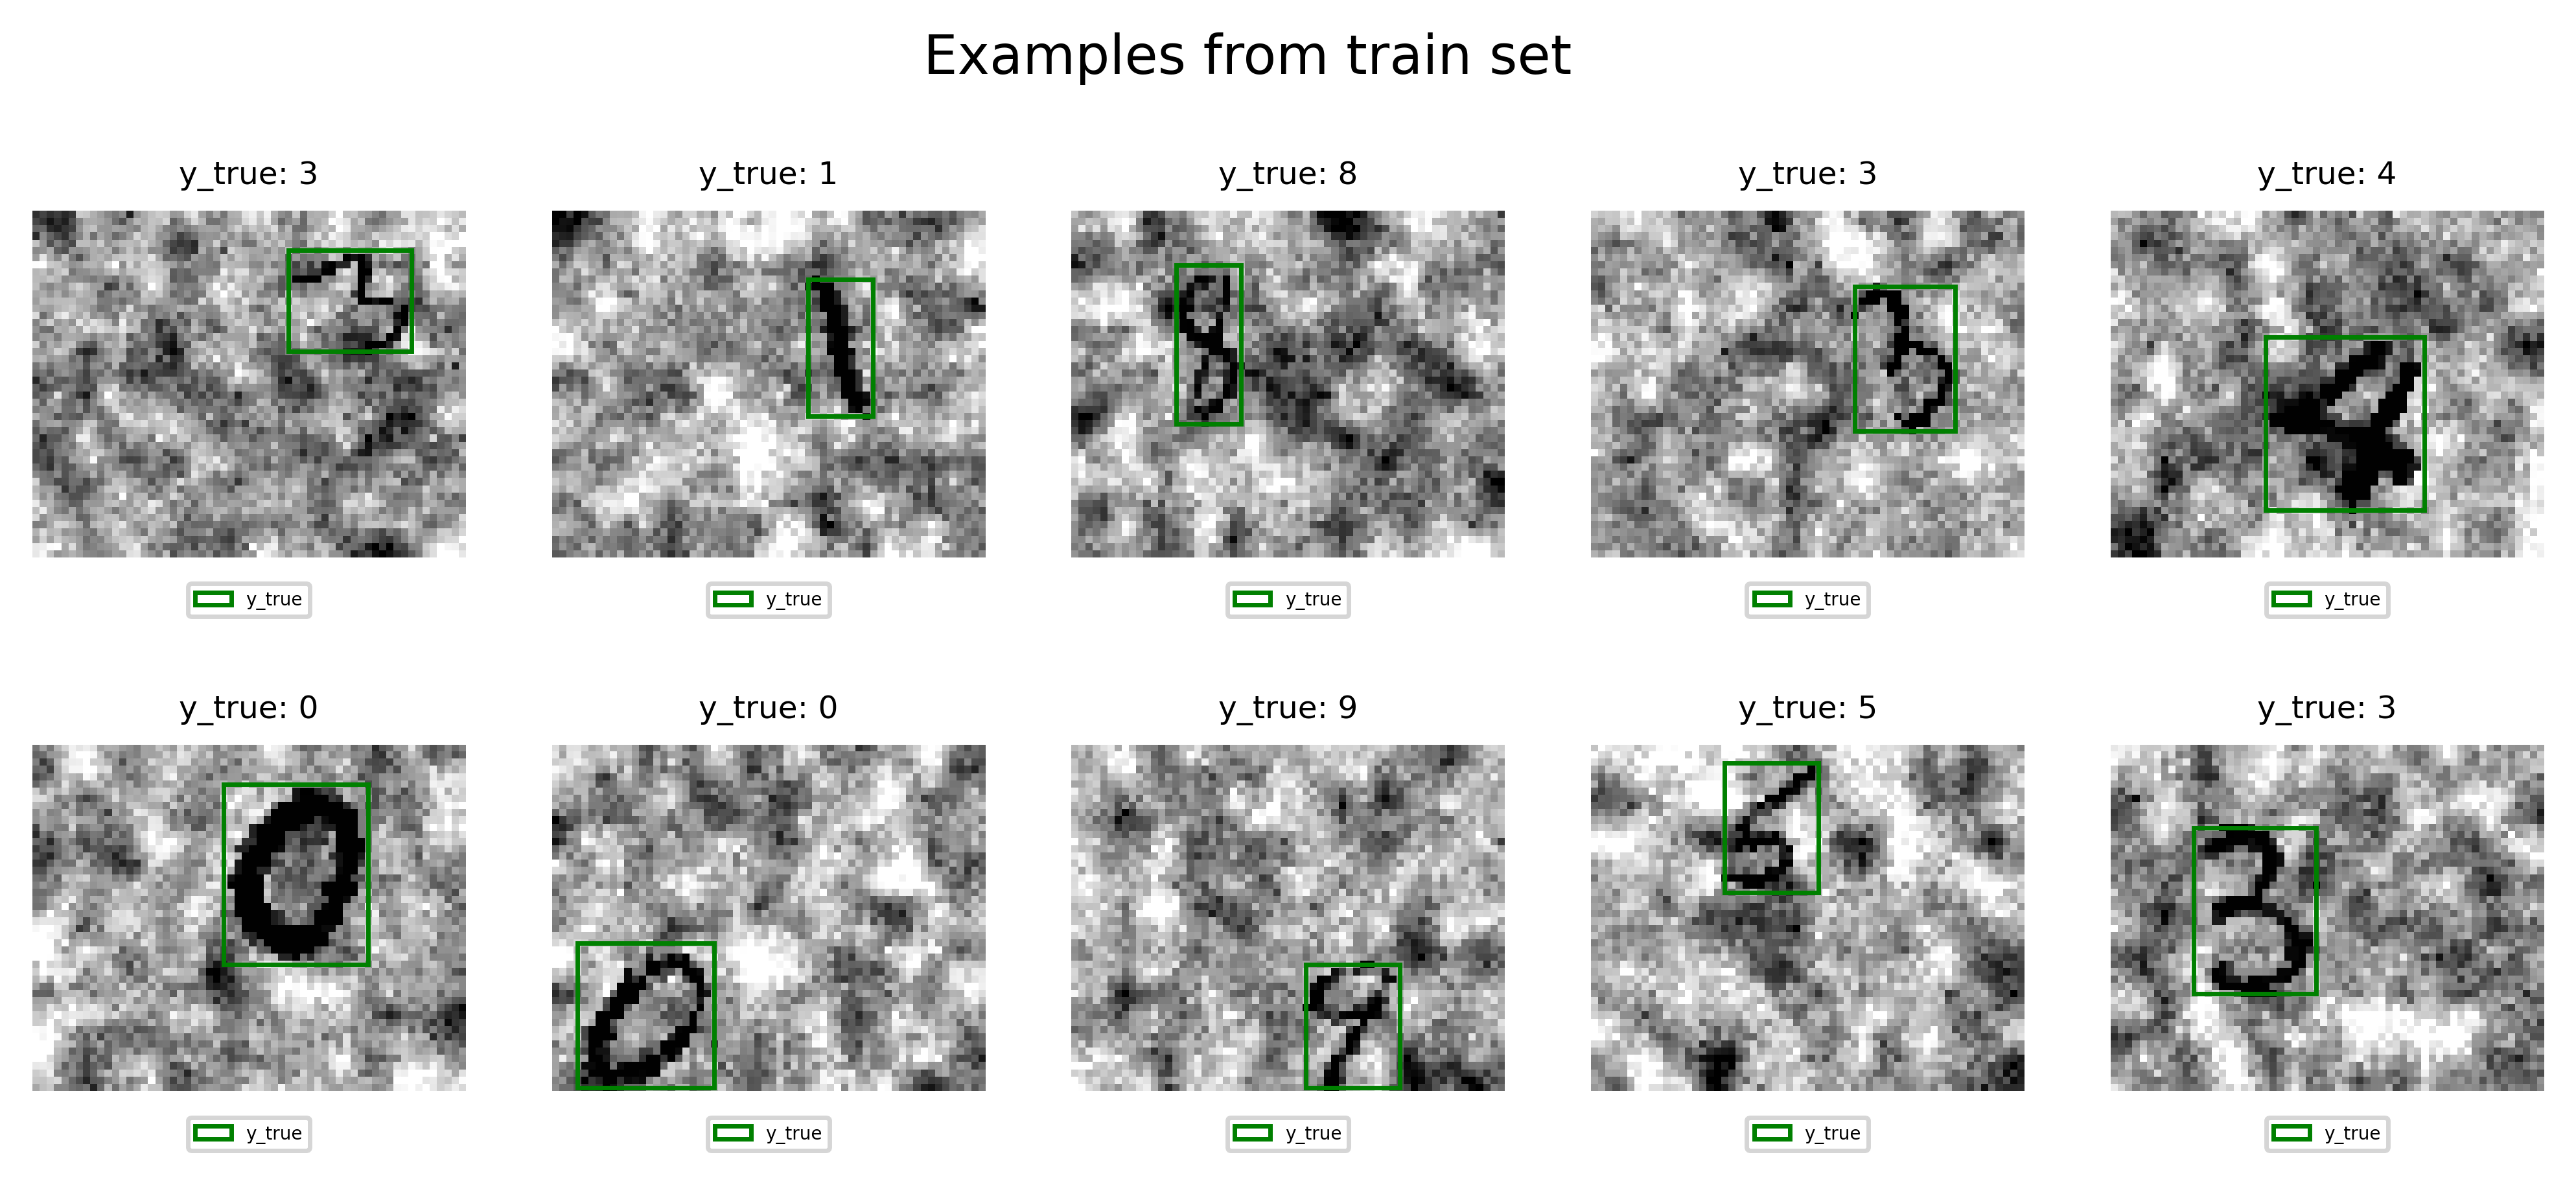

In [5]:
plot_data(localization_train, "Examples from train set")

### Task 2.2

Implement and train several convolutional models suitable for an object localization task and
the data provided

In [85]:
output_layer = 1 + 4 + 10

# Got inspiration from the LeNet5 model architecture.
# Used definition found here https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=960, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=output_layer),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out.double()


### Loss function

In image classification, the loss function is usually the cross entropy loss, (nn.CrossEntropyLoss
in pytorch), or equivalently the negative log likelihood loss of the logsoftmax of the output layer, (a
combination of F.log softmax and nn.NNLoss).
In object localization, the loss function is split into 3 components:

- A detection loss LA: ”Is there an object in the image? ”. It is defined as the binary cross
entropy loss of the sigmoid of pc. (nn.BCEWithLogitsLoss in pytorch, or a combination of
F.sigmoid and nn.BCELoss)
- A localization loss LB: ”Where is the object? ”. This can simply be the mean squared error
loss applied to [x, y, w, h] (nn.MSELoss in pytorch)
- A classification loss LC : ”Which class is this? ”. This is the same as the image classification
loss, applied to [c1, ···, cC ].

If the expected output y true is such that pc = 0 (i.e. there is no object in the image), then the
loss function Llocalization is reduced to the detection loss: Llocalization = LA.
If the expected output y true is such that pc = 1 (i.e. there is an object in the image), then the
loss function Llocalization is the sum of the 3 losses: Llocalization = LA + LB + LC .

In [86]:
BCEWithLogitsLoss = nn.BCEWithLogitsLoss()
MSELoss = nn.MSELoss()
CrossEntropyLoss = nn.CrossEntropyLoss()
NLLLoss = nn.NLLLoss()
logSoftmax = nn.LogSoftmax(dim=0)
Sigmoid = nn.Sigmoid()


def loss_fn(Y_pred, Y_true):
    L_A = BCEWithLogitsLoss(Y_pred[:, 0], Y_true[:, 0])

    # A object is considered correctly detected if sigmoid(pc) > 0.5 and the prediction is correct by y_true
    detected_mask = torch.where((Sigmoid(Y_pred[:, 0]) > 0.5) * (Y_true[:, 0] == 1))[
        0
    ]  # Using * as boolean Bitwise AND

    L_B = 0
    L_C = 0

    if len(detected_mask) > 0:
        L_B = MSELoss(Y_pred[detected_mask, 1:5], Y_true[detected_mask, 1:5])

        inp = Y_pred[detected_mask, 5:]
        target = Y_true[detected_mask, 5]
        L_C = CrossEntropyLoss(inp, target.type(torch.long))

    return L_A + L_B + L_C


### Performance

In image classification, the most commonly used performance is the accuracy. In object localization,
accuracy is still relevant, but not sufficient for it does not tell how well the model predicts bounding
boxes. In addition, its definition is slightly different as there might be images without any object at
all. The total number of images to classify is the total number of images containing an object (i.e.
when the first element pc of y true is 1). The number of correctly classified images, is the number
of predictions where both the predicted pc and the predicted label matches their counterparts in
y true. Note that interpreting the predicted pc depends on the choice of implementation of the
detection loss LA. If the sigmoid is included in the neural network as an activation function, then an
object is considered detected if pc > 0.5. Otherwise, if the sigmoid is included in the loss function,
then an object is considered detected if sigmoid(pc) > 0.5.
Performance on bounding boxes can be measured using intersection over union (IoU). This is
defined as the ratio between the area of the intersection of the box predicted and the box expected
and the area of their union. IoU is then also defined between 0 and 1.
To evaluate how well the model can classify and draw bounding boxes, an overall performance
can be defined as the mean of the accuracy and the IoU

In [87]:
SMOOTH = 1e-6

# Vectorized implementation with inspiration from https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/pytorch_automatic_optimization_jit.ipynb
def iou(pred, true):
    x1, y1, w1, h1 = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
    x2, y2, w2, h2 = true[:, 0], true[:, 1], true[:, 2], true[:, 3]

    xi = torch.max(x1, x2)
    yi = torch.max(y1, y2)

    wi = torch.clamp(torch.min(x1 + w1, x2 + w2) - xi, min=0)
    hi = torch.clamp(torch.min(y1 + h1, y2 + h2) - yi, min=0)

    intersection = wi * hi
    union = w1 * h1 + w2 * h2 - wi * hi
    return intersection / torch.clamp(union, min=SMOOTH)  # To avoid divison by zero


def continous_to_digit(pred):
    # Converting continous pc and the 10 class labels to single digits
    pred[:, 0] = (Sigmoid(pred[:, 0]) > 0.5).float()
    values, indices = torch.max(pred[:, 5:], 1, keepdim=True)

    pred[:, 5:] = indices
    pred = pred[:, :6]

    return pred


def performance(y_pred, y_true):
    y_pred = continous_to_digit(y_pred)

    # Calculating the mean of accuracy of pred vs true for the given batch
    accuracy_list = [
        1 if y_pred[i, 0] == y_true[i, 0] and y_pred[i, 5] == y_true[i, 5] else 0
        for i in range(len(y_pred))
    ]
    accuracy = torch.mean(torch.Tensor(accuracy_list))

    # Calculating the mean of IOU for the given batch
    iou_list = iou(y_pred[:, 1:5], y_true[:, 1:5])
    iou_res = torch.mean(iou_list)

    # Returning the mean of the two measures
    return [torch.mean(torch.Tensor([accuracy, iou_res])), iou_res, accuracy]


In [88]:
def train(n_epochs, optimizer, model, loss_fn, loader):
    steps = len(loader)

    model.train()

    losses = []
    scores = []

    with tqdm(total=steps) as pbar:
        for epoch in range(1, n_epochs + 1):
            pbar.set_description(f"epoch: {epoch}")
            loss_list = []
            score_list = []

            for i, (imgs, Y_true) in enumerate(loader):
                pbar.update(1)

                imgs = imgs.to(device=device, dtype=torch.double)
                Y_true = Y_true.to(device=device)

                Y_pred = model(imgs)

                loss = loss_fn(Y_pred.float(), Y_true.float())
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                score = performance(Y_pred, Y_true)[0]
                score_list.append(score.item())
                loss_list.append(loss.item())

            scores.append(mean(score_list))
            losses.append(mean(loss_list))
            pbar.reset()

    return scores, losses


### LeNet5 model instance

We tried differnet parameters for batch size and learning rate and tested with low epochs. A batch size of 64 and learning rate of 0.001 converged the best of values tested

In [105]:
batch_size = 128
lr = 0.001
epochs = 30

train_loader = torch.utils.data.DataLoader(
    localization_train, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(localization_val, batch_size=1, shuffle=True)

LeNet5_model = LeNet5().to(device)
LeNet5_optimizer = torch.optim.Adam(LeNet5_model.parameters(), lr=lr)

scores, losses = train(epochs, LeNet5_optimizer, LeNet5_model, loss_fn, train_loader)


  0%|          | 0/422 [00:00<?, ?it/s]

In [106]:
def plot_training_data(scores, losses, title):
    df = pandas.DataFrame(
        list(zip(scores, losses)), columns=["Performance", "Training loss"]
    )
    
    df["Training loss"] = df["Training loss"] / df["Training loss"].loc[
        df["Training loss"].abs().idxmax()
    ].astype(np.float64)


    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(df["Performance"]) + 1)),
            y=df["Performance"],
            name="Performance (mean of accuracy and IOU)",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(df["Performance"]) + 1)),
            y=df["Training loss"],
            name="Training loss (max value normalized to 0-1 range)",
        )
    )

    fig.update_layout(
        title=title,
        xaxis_title="Epoch",
        xaxis=dict(tickmode="linear", tick0=1, dtick=1),
        yaxis_title="Value",
        legend_title="Measure",
    )

    fig.update_yaxes(rangemode="tozero")

    fig.show()


In [107]:
plot_training_data(
    scores,
    losses,
    f"Performance and Training loss of LeNet5 with lr:{lr} and batch_size:{batch_size}",
)


When we ran the LeNet5 model for 15 epochs in 18 minutes, it did not converge well to better performance. Towards the last epochs we saw a performance boost, so it may be that this model can get better for larger epochs.

Let us check the performance of the validation set compared to training.

In [92]:
def check_performance(model, loaders, performance_fn, detection = False):
    model.eval()
    ret = []
    for name, loader in loaders:
        with tqdm(total=len(loader)) as pbar:
            pbar.set_description(f"Checking performance for {name} data")
            performance_list = []
            iou_list = []
            accuracy_list = []
            with torch.no_grad():
                for imgs, Y_true in loader:
                    pbar.update(1)
                    imgs = imgs.to(device=device, dtype=torch.double)
                    Y_true = Y_true.to(device=device)

                    Y_pred = model(imgs)

                    if detection:
                        Y_pred = Y_pred.reshape([Y_pred.size()[0], 2, 3, 7])

                    p_list = performance_fn(Y_pred, Y_true)
                    performance_i = p_list[0]
                    performance_list.append(performance_i.item())

                    iou_i = p_list[1]
                    iou_list.append(iou_i.item())
                    accuracy_i = p_list[2]
                    accuracy_list.append(accuracy_i.item())

        performance = mean(performance_list)
        iou = mean(iou_list)
        accuracy = mean(accuracy_list)
        print("Performance {} data: {:.2f}".format(name, performance))
        print("IOU {} data: {:.2f}".format(name, iou))
        print("Accuracy {} data: {:.2f}".format(name, accuracy))
        ret.append(performance)

    return ret


In [93]:
LeNet5_performance = check_performance(
    LeNet5_model, [("training", train_loader), ("validation", val_loader)], performance
)


  0%|          | 0/422 [00:00<?, ?it/s]

Performance training data: 0.49
IOU training data: 0.38
Accuracy training data: 0.61


  0%|          | 0/6000 [00:00<?, ?it/s]

Performance validation data: 0.38
IOU validation data: 0.38
Accuracy validation data: 0.38


We see that the model performs similar with the training and validation set, so it is not overfitted.

In [94]:
models_val_performance = {}
models_val_performance[LeNet5_performance[1]] = LeNet5_model #Storing accuracy of validation set for model selction later

Let us take a look at what the LeNet5 model predicts with examples from validation

In [95]:
def visualize_pred(model, loader, title):
    COL = 5
    ROW = 2
    fig = plt.figure(figsize=(10, 4), dpi=500)

    for index in range(1, COL * ROW + 1):
        plt.subplot(ROW, COL, index)
        plt.axis("off")

        batch = next(iter(loader))

        imgs, Y_true = batch

        imgs = imgs.to(device=device, dtype=torch.double)
        Y_pred = model(imgs)
        Y_pred = continous_to_digit(Y_pred)

        imgs = imgs.cpu()
        Y_pred = Y_pred.data.cpu()

        plt.imshow(imgs[0][0], cmap="gray_r")
        plt.title(
            f"y_true: {int(Y_true[0][5])}, y_pred: {int(Y_pred[0][5])}",
            fontsize=7,
        )

        x_t, y_t, w_t, h_t = to_lower_xy(Y_true[0])
        rect_t = Rectangle(
            (x_t, y_t), w_t, h_t, linewidth=1, edgecolor="g", facecolor="none"
        )

        x_p, y_p, w_p, h_p = to_lower_xy(Y_pred[0])
        rect_p = Rectangle(
            (x_p, y_p),
            w_p,
            h_p,
            linewidth=1,
            edgecolor="m",  # One should never use red/green as differentiating colors since this is the most common color blindness
            facecolor="none",
        )

        ax = plt.gca()
        ax.add_patch(rect_t)
        ax.add_patch(rect_p)
        ax.legend(
            ["y_true", "y_pred"],
            fontsize=4,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            ncol=1,
        )
    fig.suptitle(title)
    fig.show()


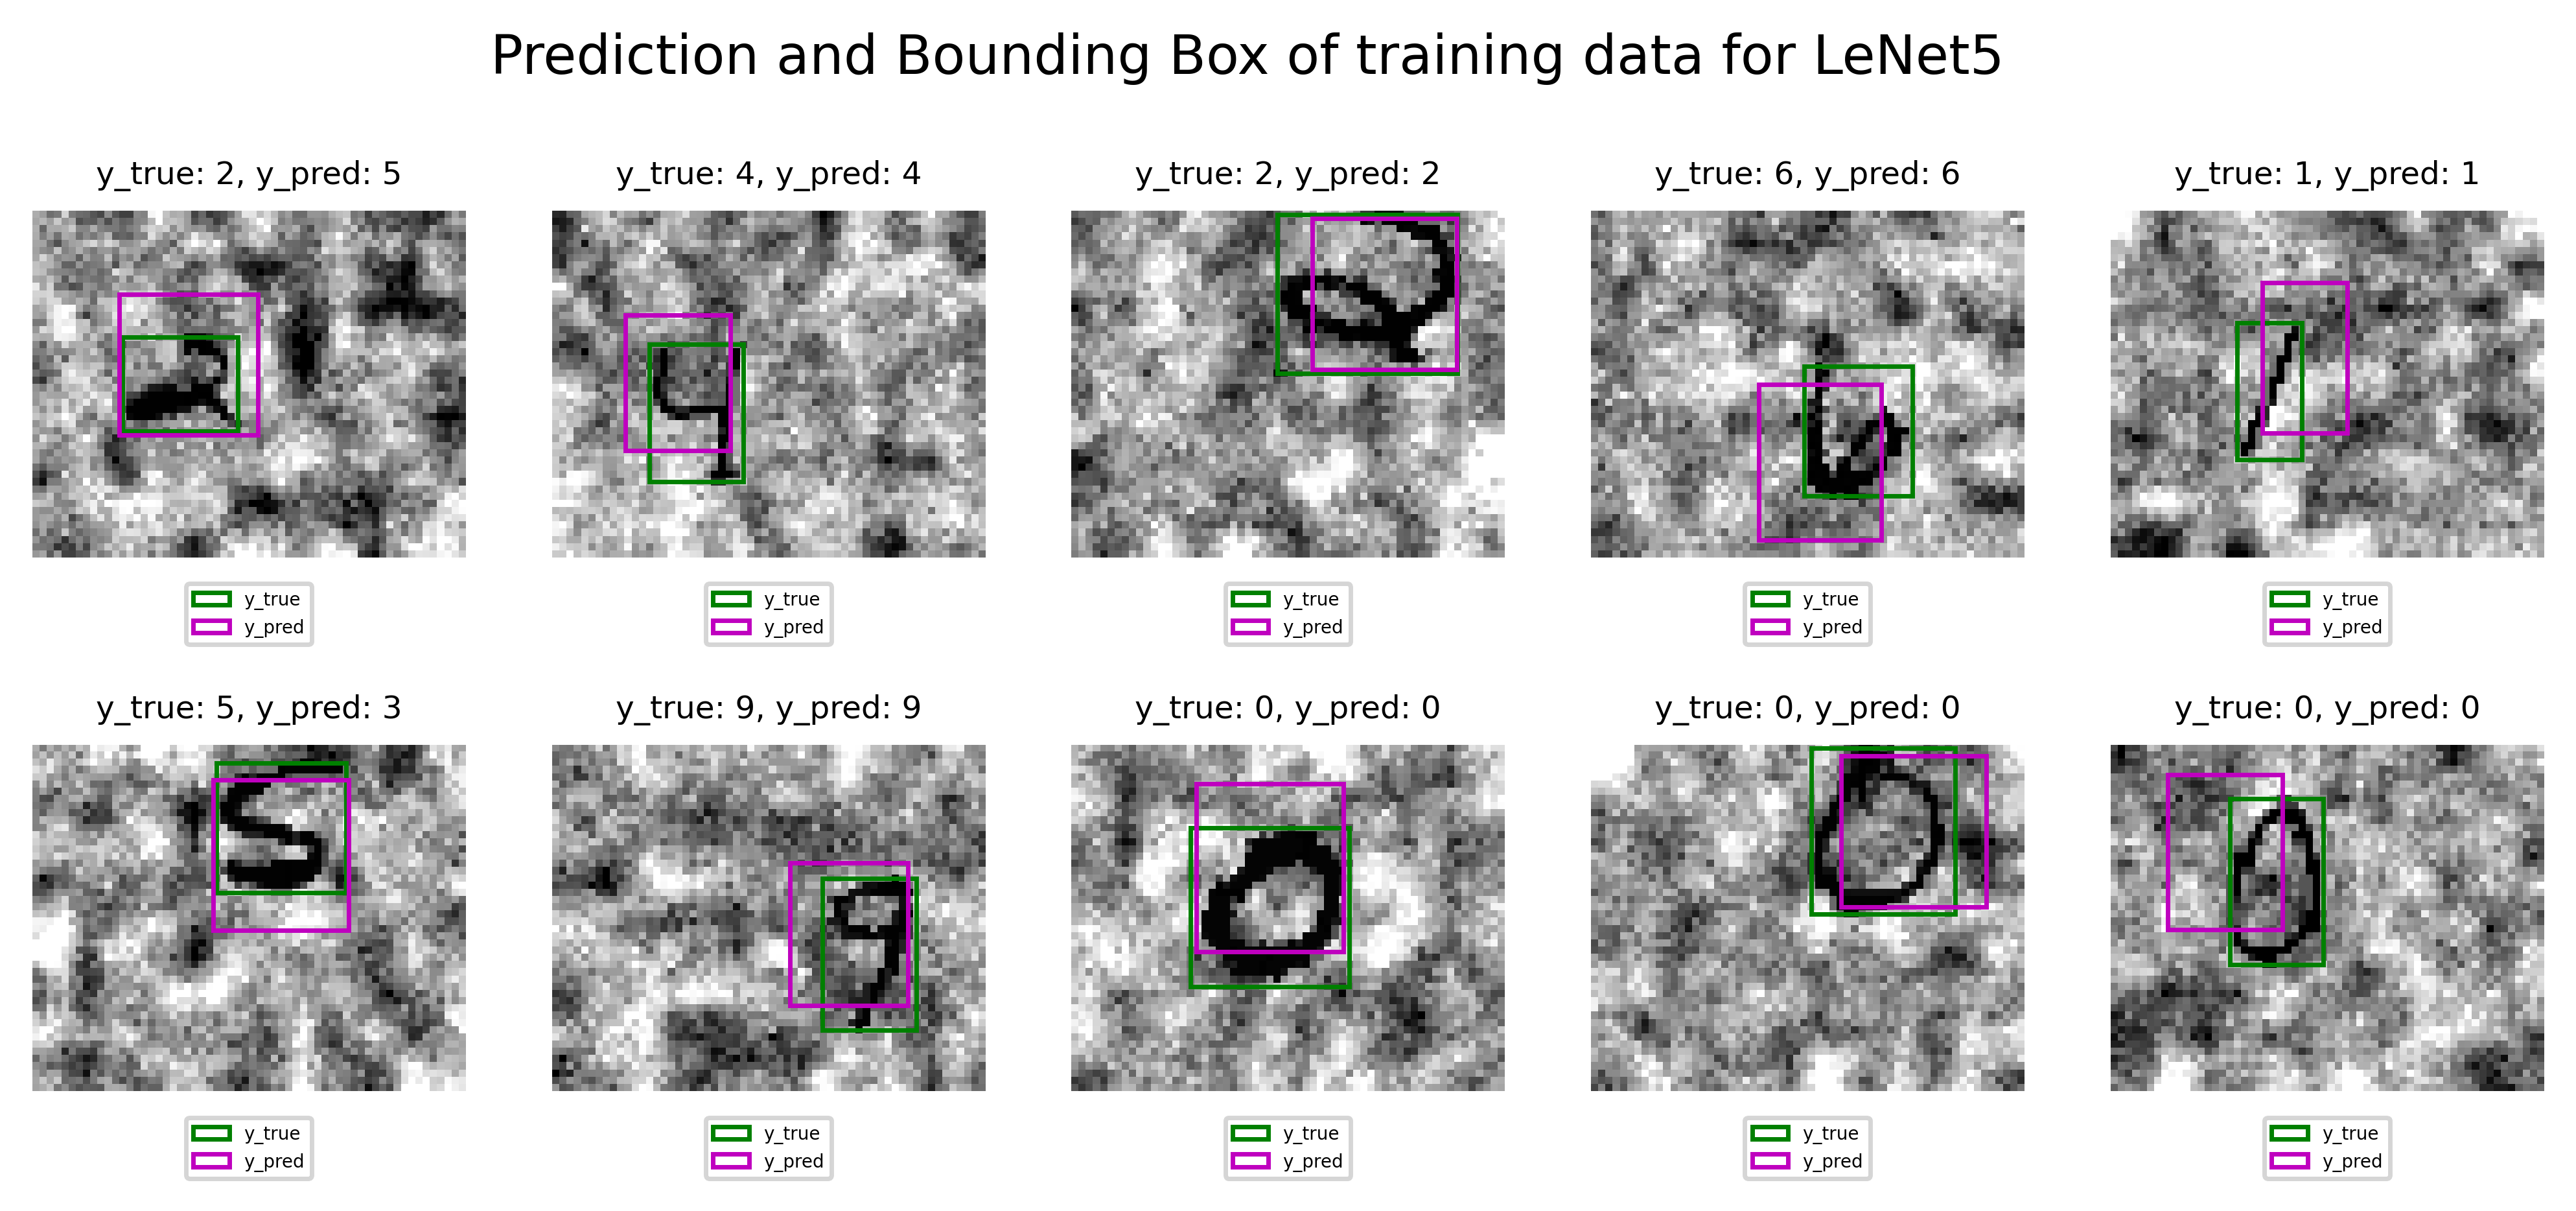

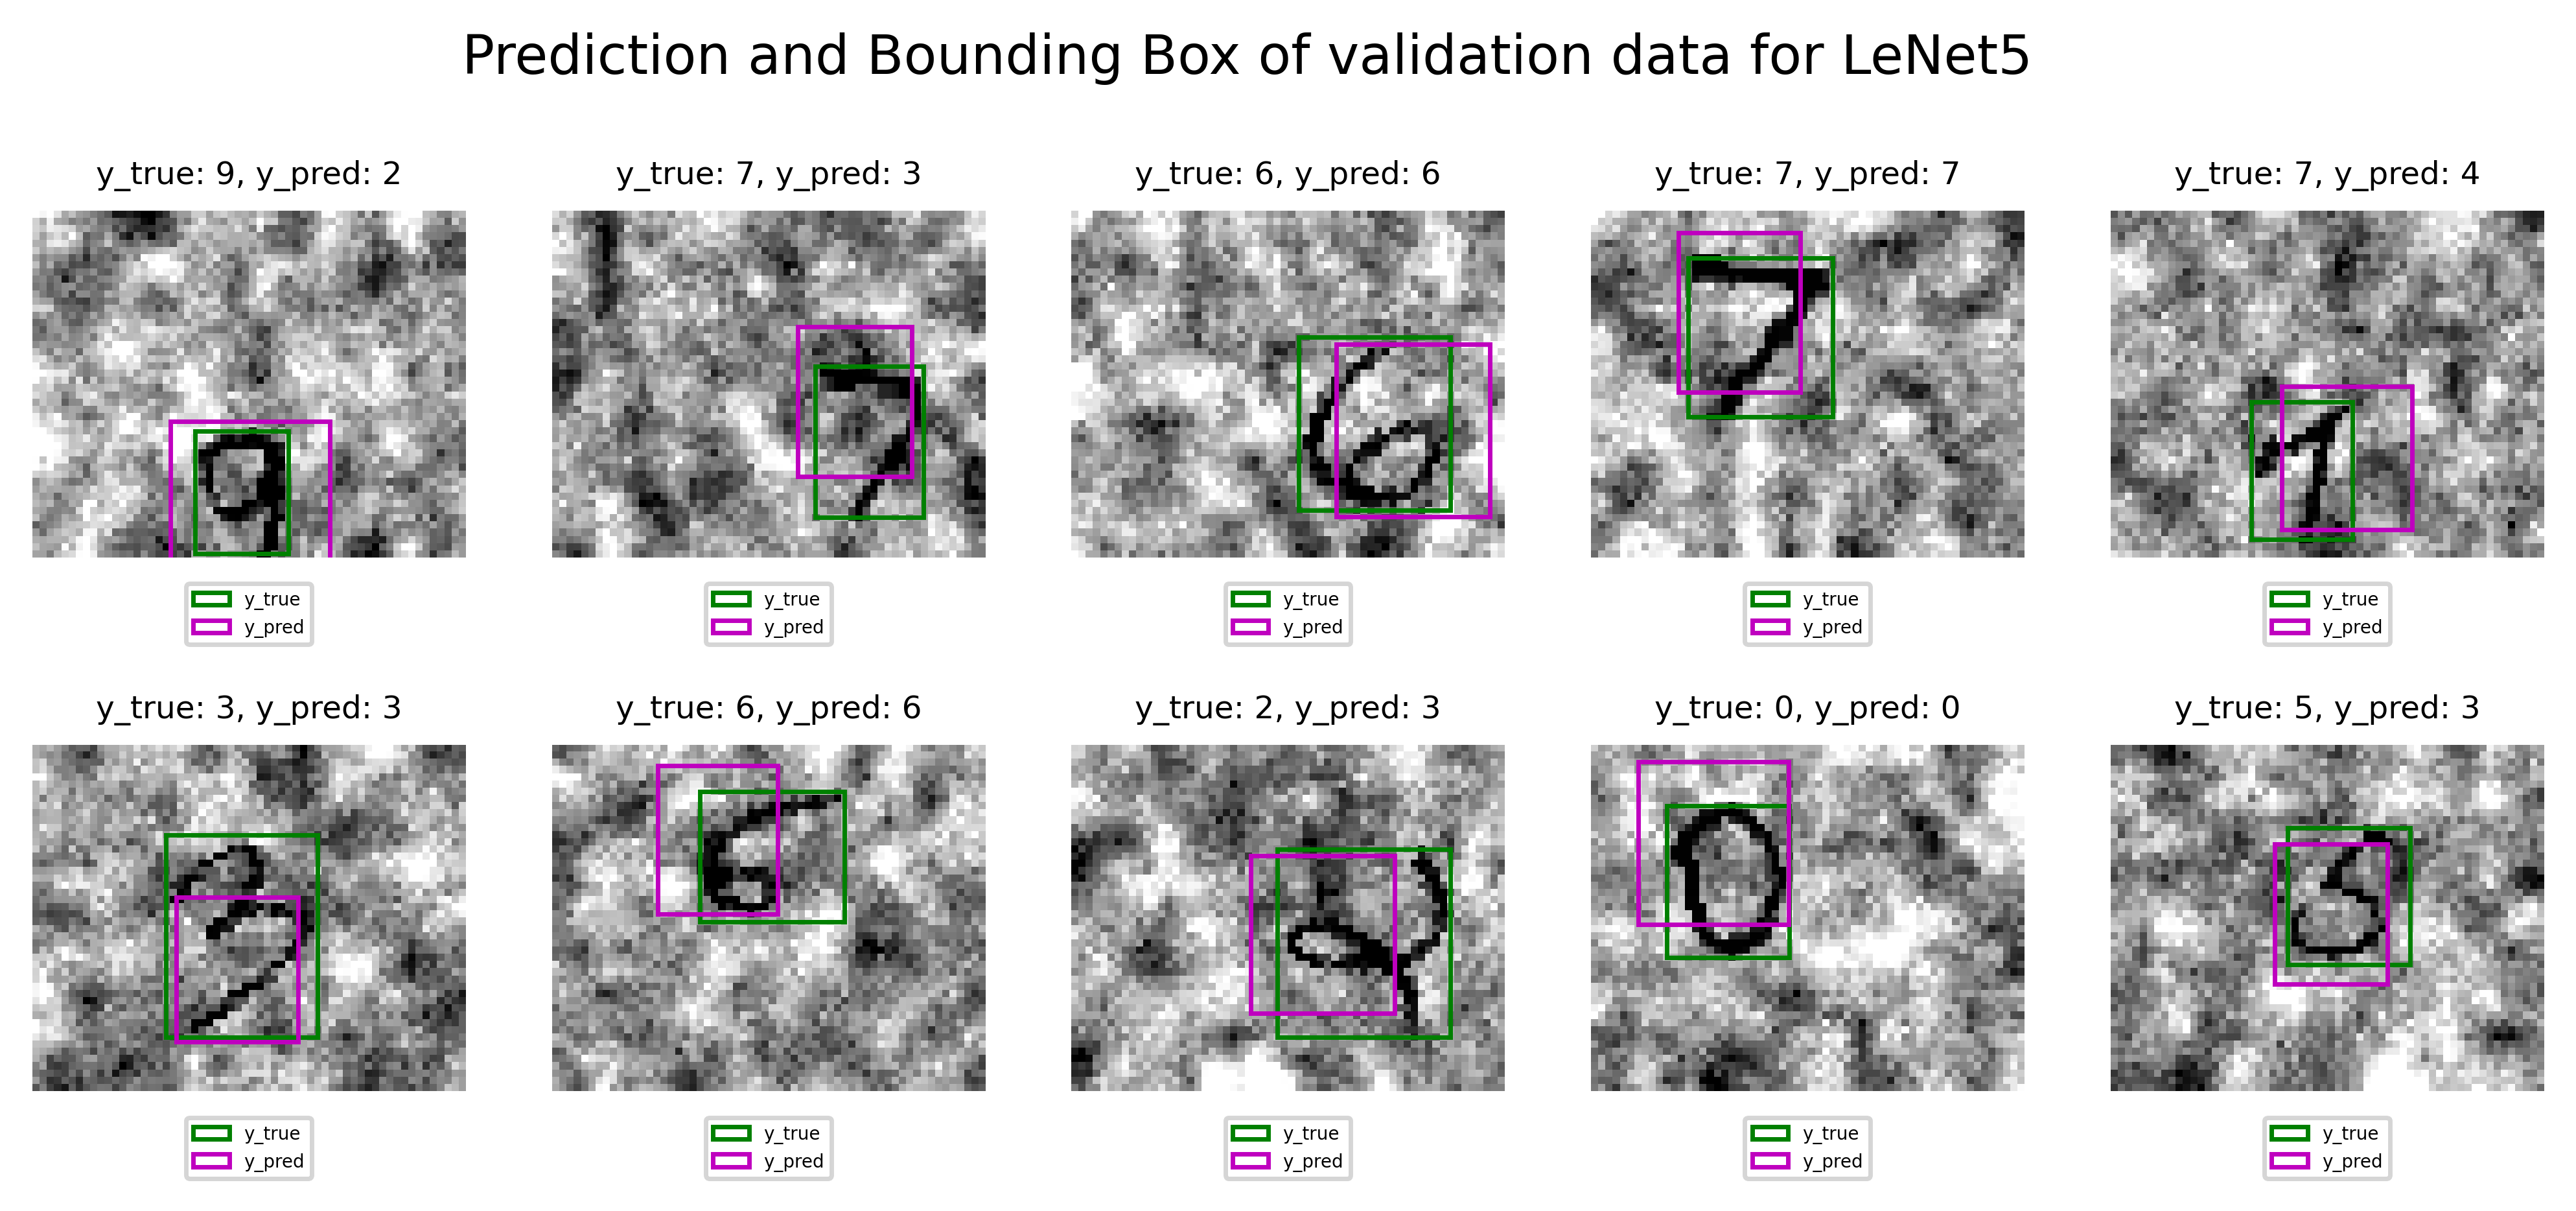

In [96]:
visualize_pred(LeNet5_model, train_loader, "Prediction and Bounding Box of training data for LeNet5")
visualize_pred(LeNet5_model, val_loader, "Prediction and Bounding Box of validation data for LeNet5")


### MyModel

We have tested several different configurations of a custom model for the dataset. It was quite compute heavy so we did include all minor adjustments tested in the notebook, because it would take too long to run. The following model is the result of the tweaking. We tested with different batch_sizes and learning rate, we adjusted the depth of the convulational layers. We tested with AvgPool, MaxPool and BatchNorm. We found that ReLU gave us better performance than Tanh as activator. We also tested different Optimizers such as SGD, RMSprop and Adagrad.

In [97]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1728, out_features=900),
            nn.ReLU(),
            nn.Linear(in_features=900, out_features=400),
            nn.ReLU(),
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=output_layer),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out.double()


In [98]:
batch_size = 128
lr = 0.0005
epochs = 30

my_model = MyModel().to(device)
my_model_optimizer = torch.optim.AdamW(my_model.parameters(), lr=lr)

scores, losses = train(epochs, my_model_optimizer, my_model, loss_fn, train_loader)


  0%|          | 0/422 [00:00<?, ?it/s]

In [99]:
plot_training_data(
    scores,
    losses,
    f"Performance and Training loss of MyModel with lr:{lr} and batch_size:{batch_size}",
)


We see much better results of training with our tweaked MyModel. We do however see a local minimum at performance

In [100]:
my_model_performance = check_performance(
    my_model, [("training", train_loader), ("validation", val_loader)], performance
)

models_val_performance[
    my_model_performance[1]
] = my_model  # Storing accuracy of validation set for model selction later


  0%|          | 0/422 [00:00<?, ?it/s]

Performance training data: 0.74
IOU training data: 0.48
Accuracy training data: 0.99


  0%|          | 0/6000 [00:00<?, ?it/s]

Performance validation data: 0.63
IOU validation data: 0.48
Accuracy validation data: 0.79


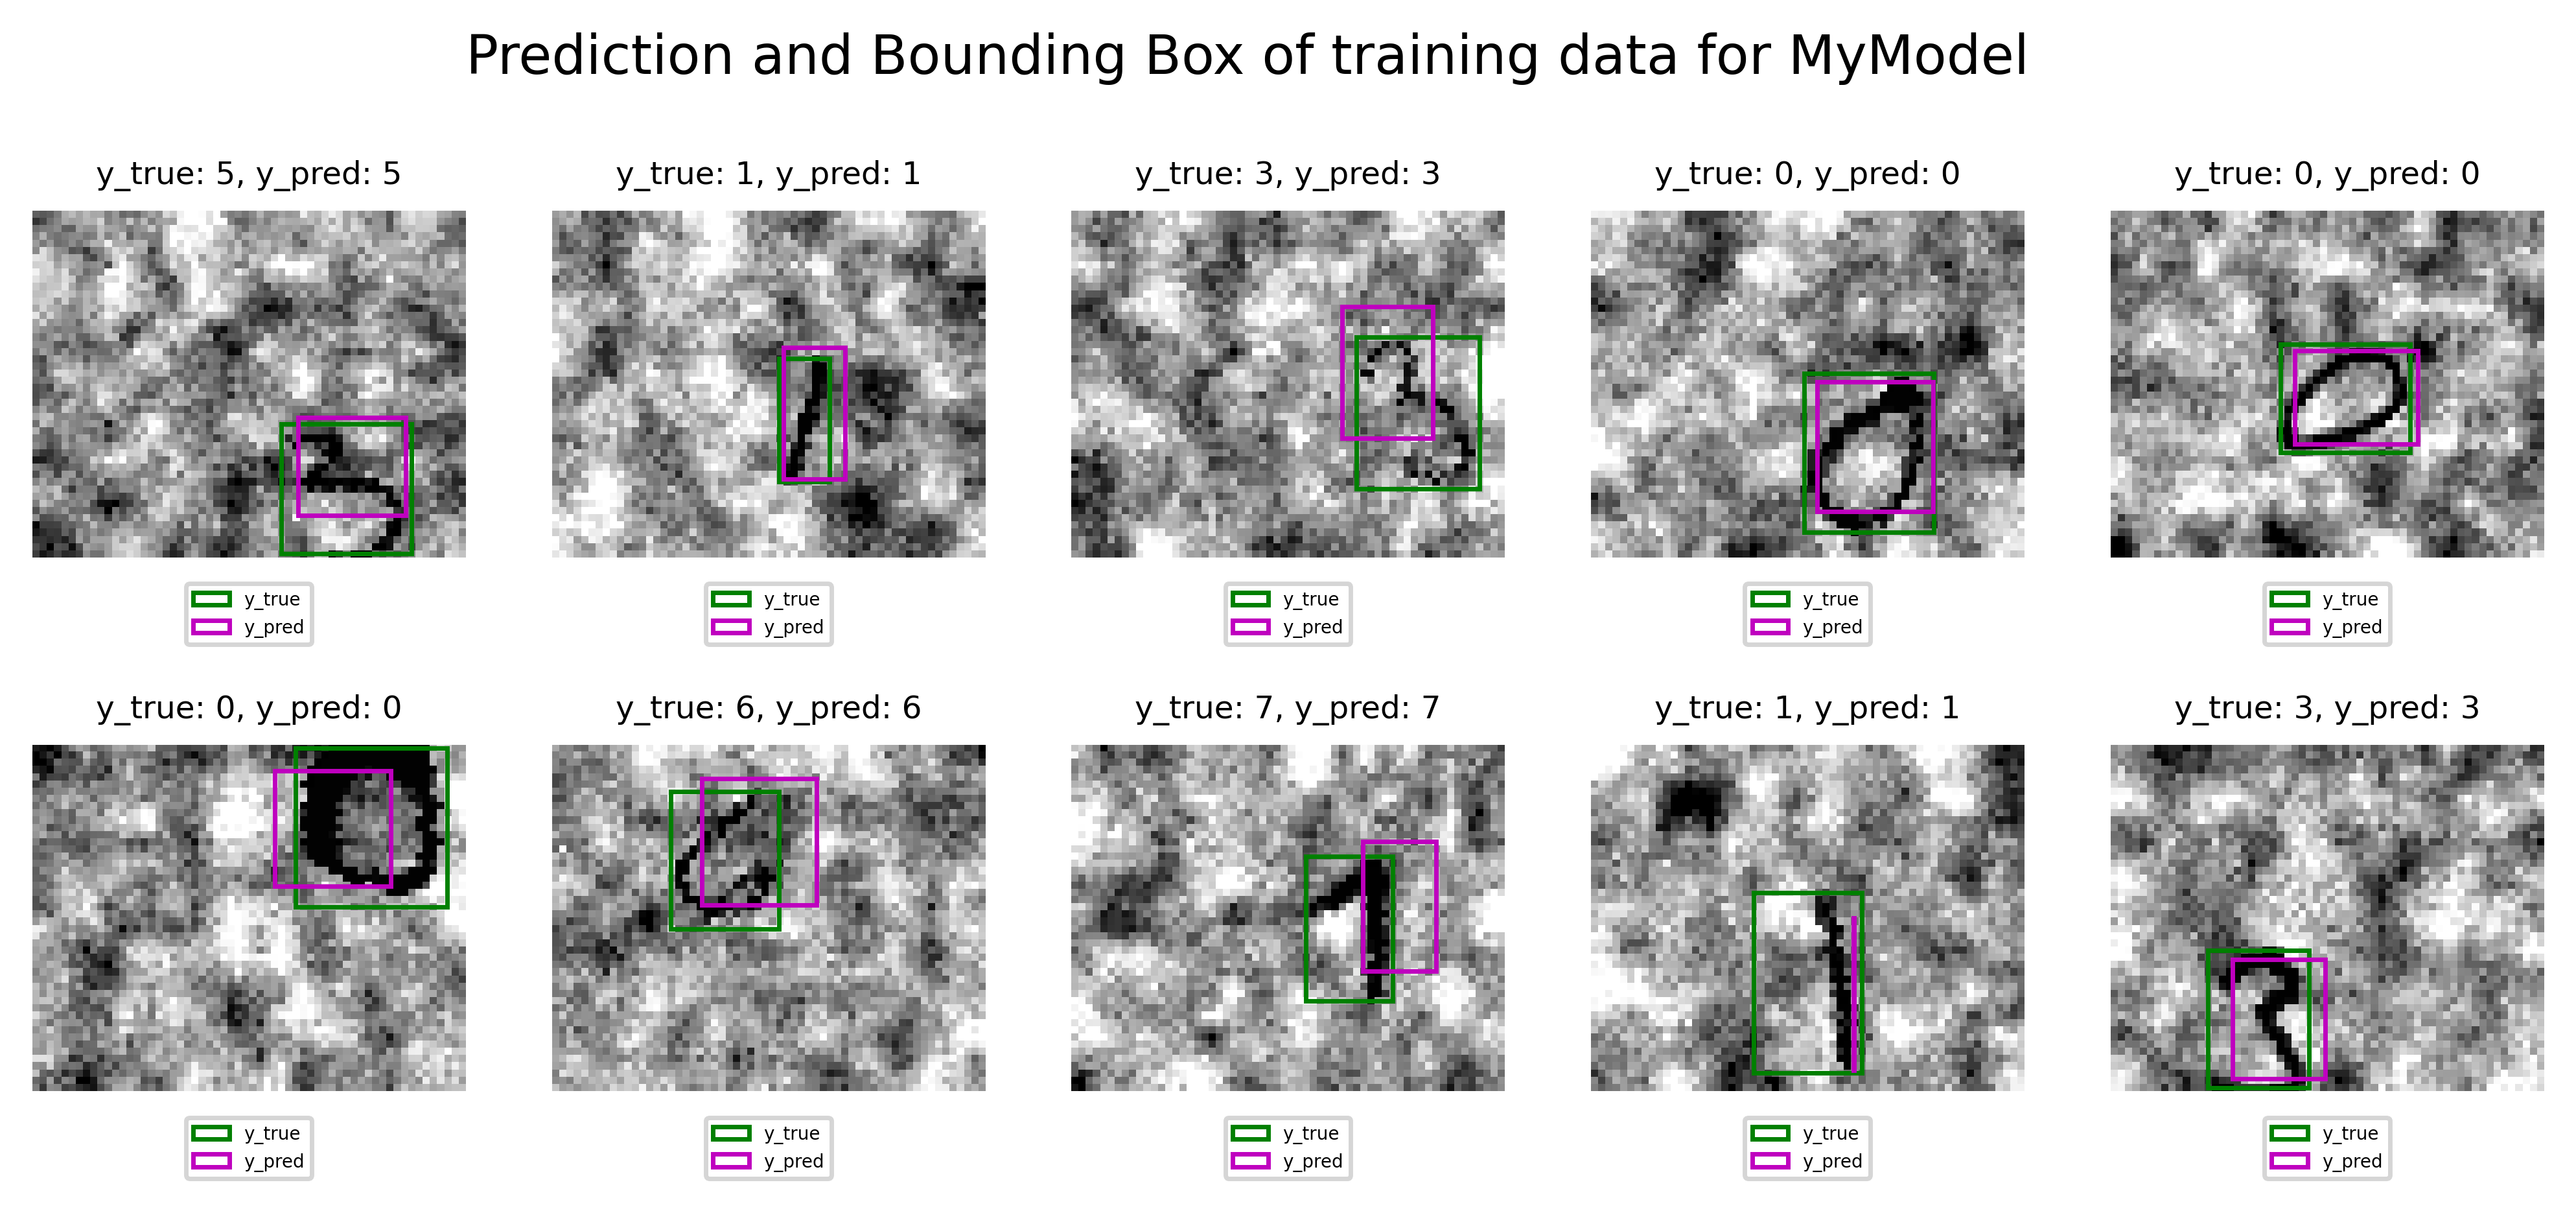

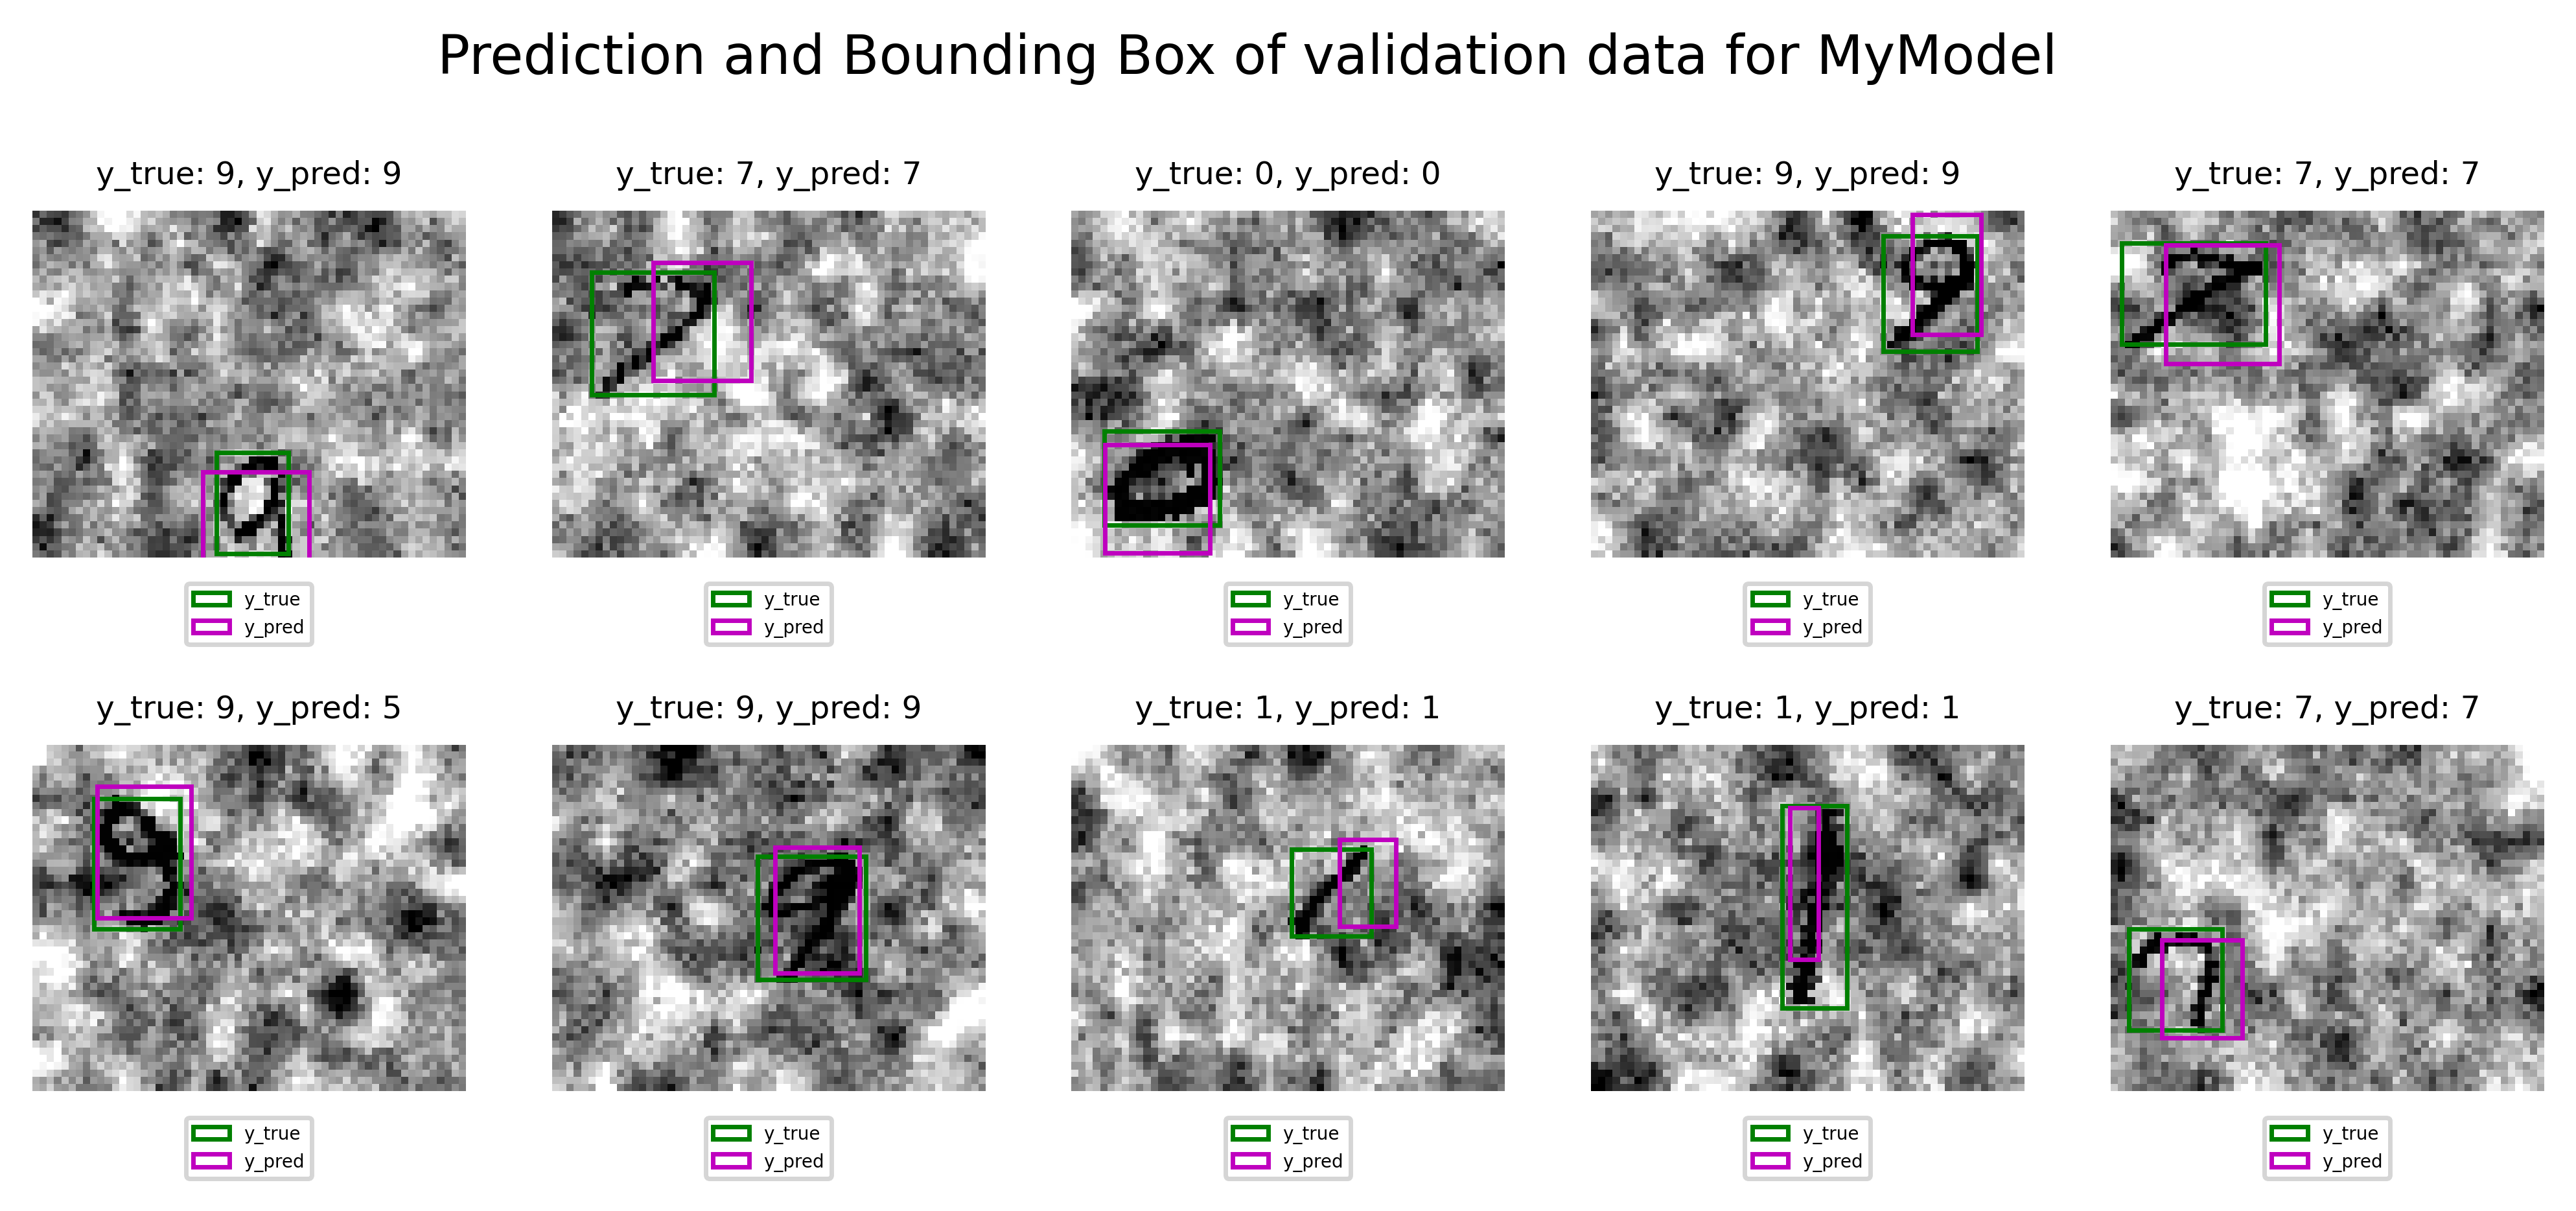

In [101]:
visualize_pred(
    my_model, train_loader, "Prediction and Bounding Box of training data for MyModel"
)

visualize_pred(
    my_model, val_loader, "Prediction and Bounding Box of validation data for MyModel"
)


In [102]:
best_model = models_val_performance[sorted(models_val_performance.keys())[-1]]

test_loader = torch.utils.data.DataLoader(localization_test, batch_size=1, shuffle=True)
best_model_performance = check_performance(my_model, [("test", test_loader)], performance)


  0%|          | 0/10000 [00:00<?, ?it/s]

Performance test data: 0.63
IOU test data: 0.47
Accuracy test data: 0.79


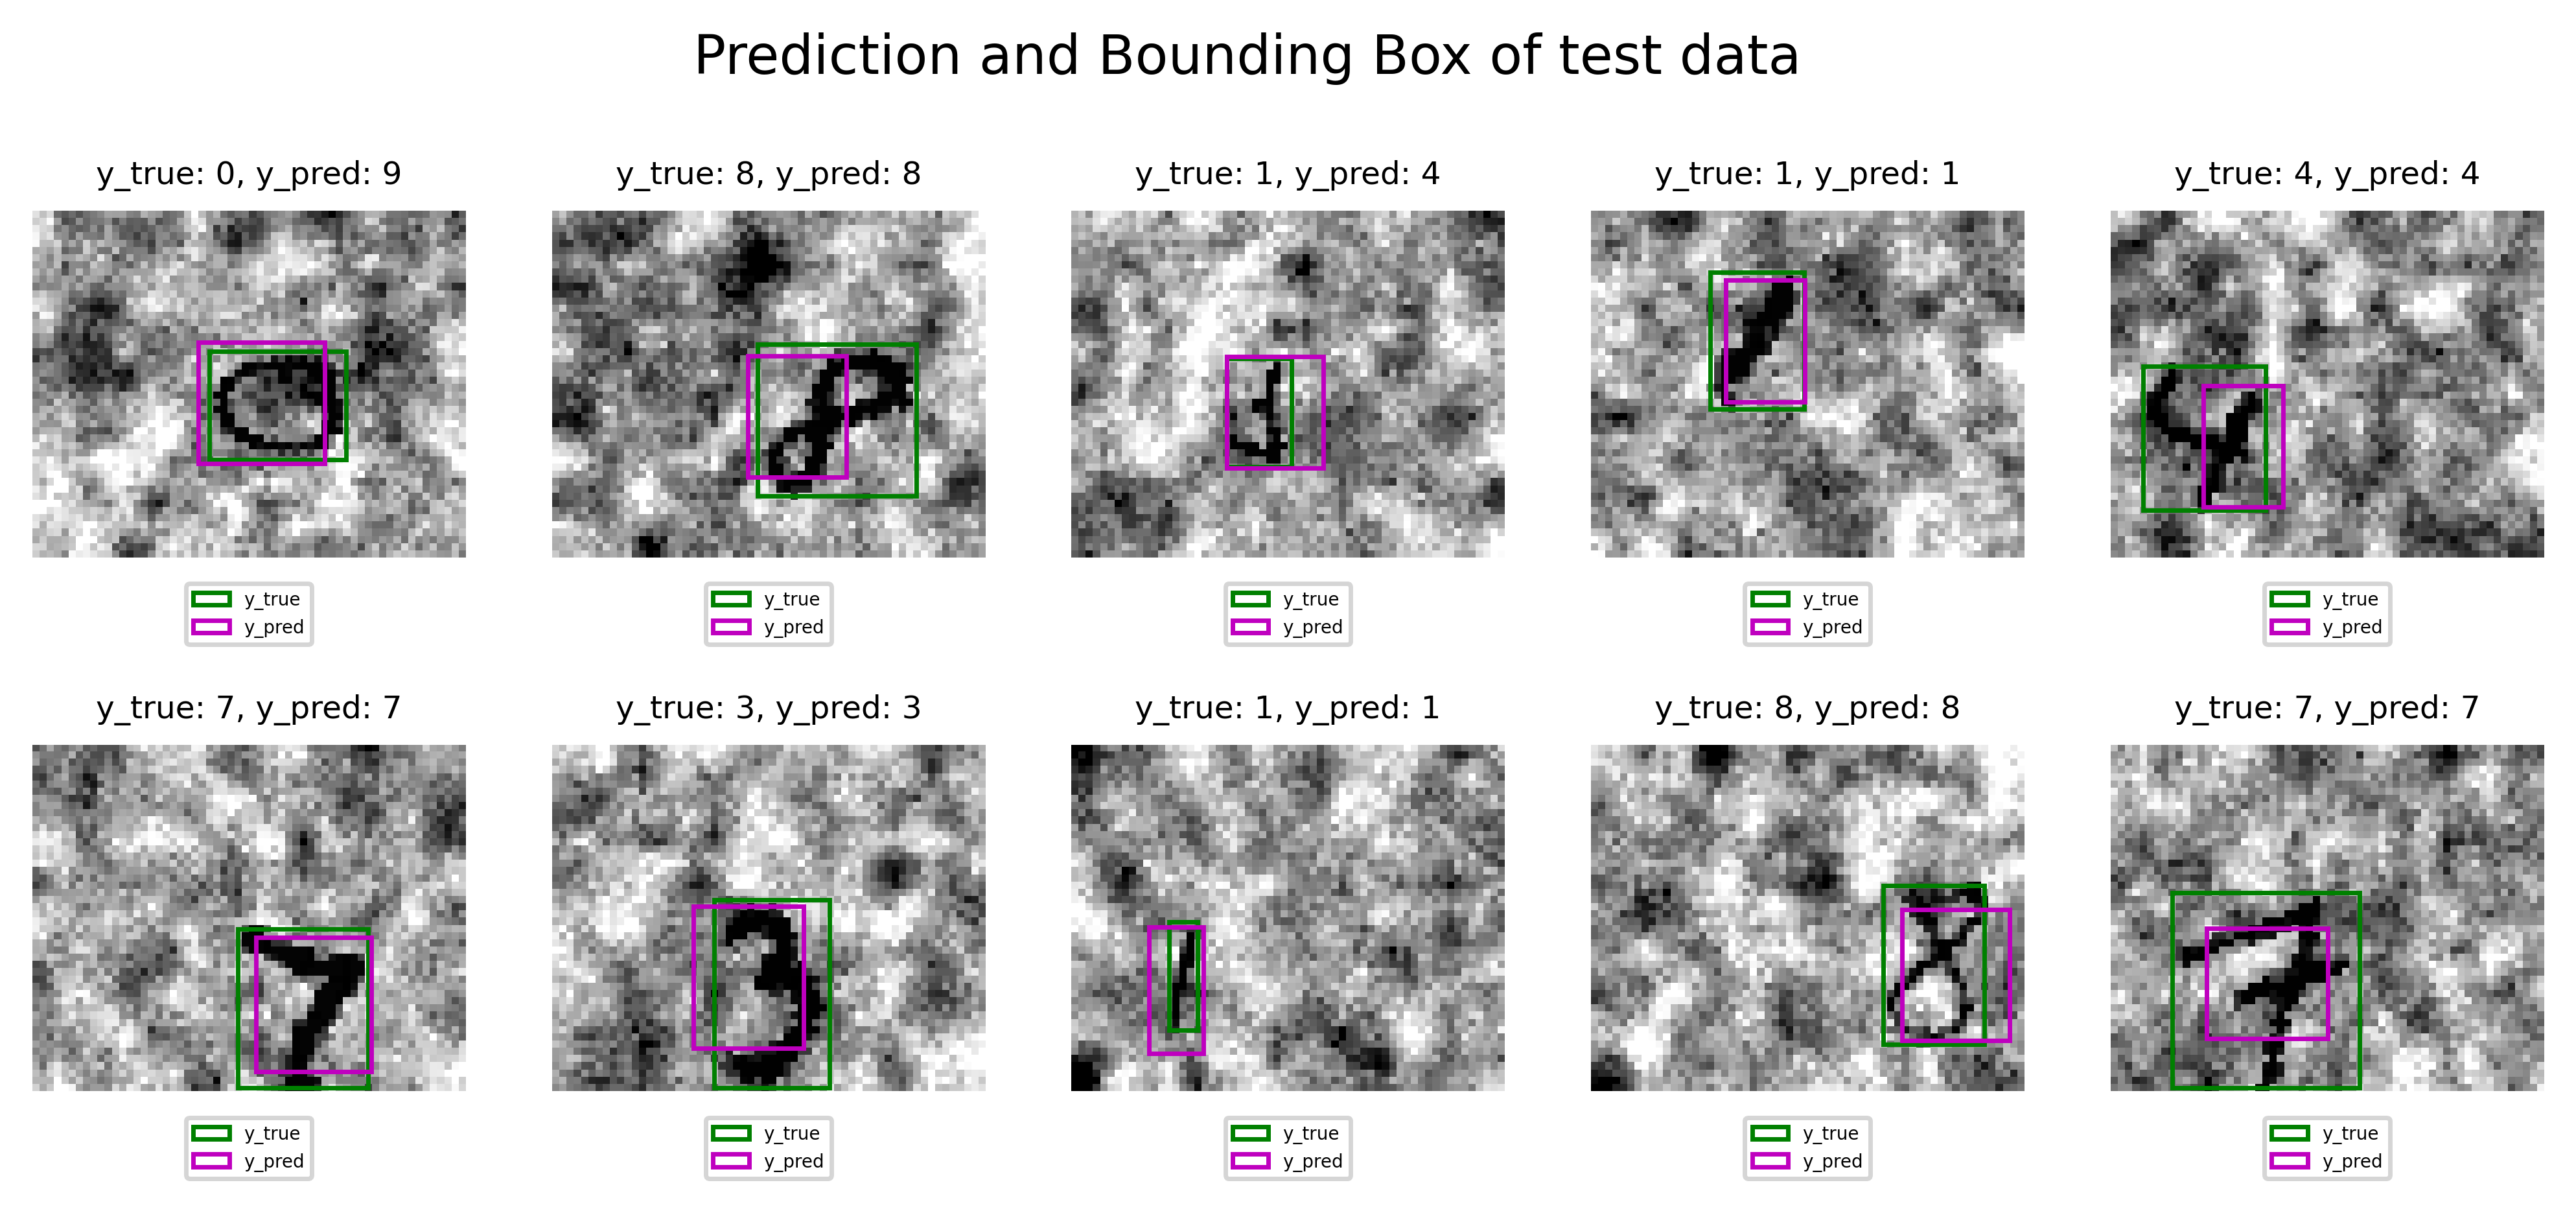

In [103]:
visualize_pred(best_model, test_loader, "Prediction and Bounding Box of test data")


## Object Detection

### Task 3.1

Load the 3 detection datasets detection XXX.pt. There can be an arbitrary number of digits
per image, the only condition is that there is no overlap between digits. To facilitate the
training, only 0 and 1 are kept (C = 2). y true is already processed for a 2 ×3 grid, each cell
of dimension 24 ×20. For the following questions, we then have Hout = 2 and Wout = 3 and
y true is a tensor of shape (Ntot, Hout, Wout, 6) with Ntot, the total number of images in the
dataset

In [7]:
detection_train = torch.load("./data/detection_train.pt")
detection_test = torch.load("./data/detection_test.pt")
detection_val = torch.load("./data/detection_val.pt")


Let us take a look at the object detection data

In [8]:
def detection_to_lower_xy(input, H, W):
    scale_w = 20
    scale_h = 24
    x = input[1] * scale_w
    y = input[2] * scale_h
    w = input[3] * scale_w
    h = input[4] * scale_h

    lower_x = x - w / 2
    lower_y = y - h / 2

    return lower_x + (scale_w * W), lower_y + (scale_h * H), w, h


def plot_detection_data(data, title):

    COL = 5
    ROW = 2
    fig = plt.figure(figsize=(10, 4), dpi=500)

    for index in range(1, COL * ROW + 1):
        plt.subplot(ROW, COL, index)
        plt.axis("off")
        plt.imshow(data.tensors[0][index][0], cmap="gray_r")

        for h, list_y_true in enumerate(data.tensors[1][index]):
            for w, y_true in enumerate(list_y_true):
                if y_true[0] == 1:
                    draw_x, draw_y, draw_w, draw_h = detection_to_lower_xy(y_true, h, w)
                    rect = Rectangle(
                        (draw_x, draw_y),
                        draw_w,
                        draw_h,
                        linewidth=1,
                        edgecolor="g",
                        facecolor="none",
                    )
                    ax = plt.gca()
                    ax.add_patch(rect)
                    t = plt.text(
                        draw_x, draw_y - 1, f"y_true:{int(y_true[5])}", fontsize=4
                    )
                    t.set_bbox(dict(facecolor="green", alpha=0.3, edgecolor="green"))

    fig.suptitle(title)


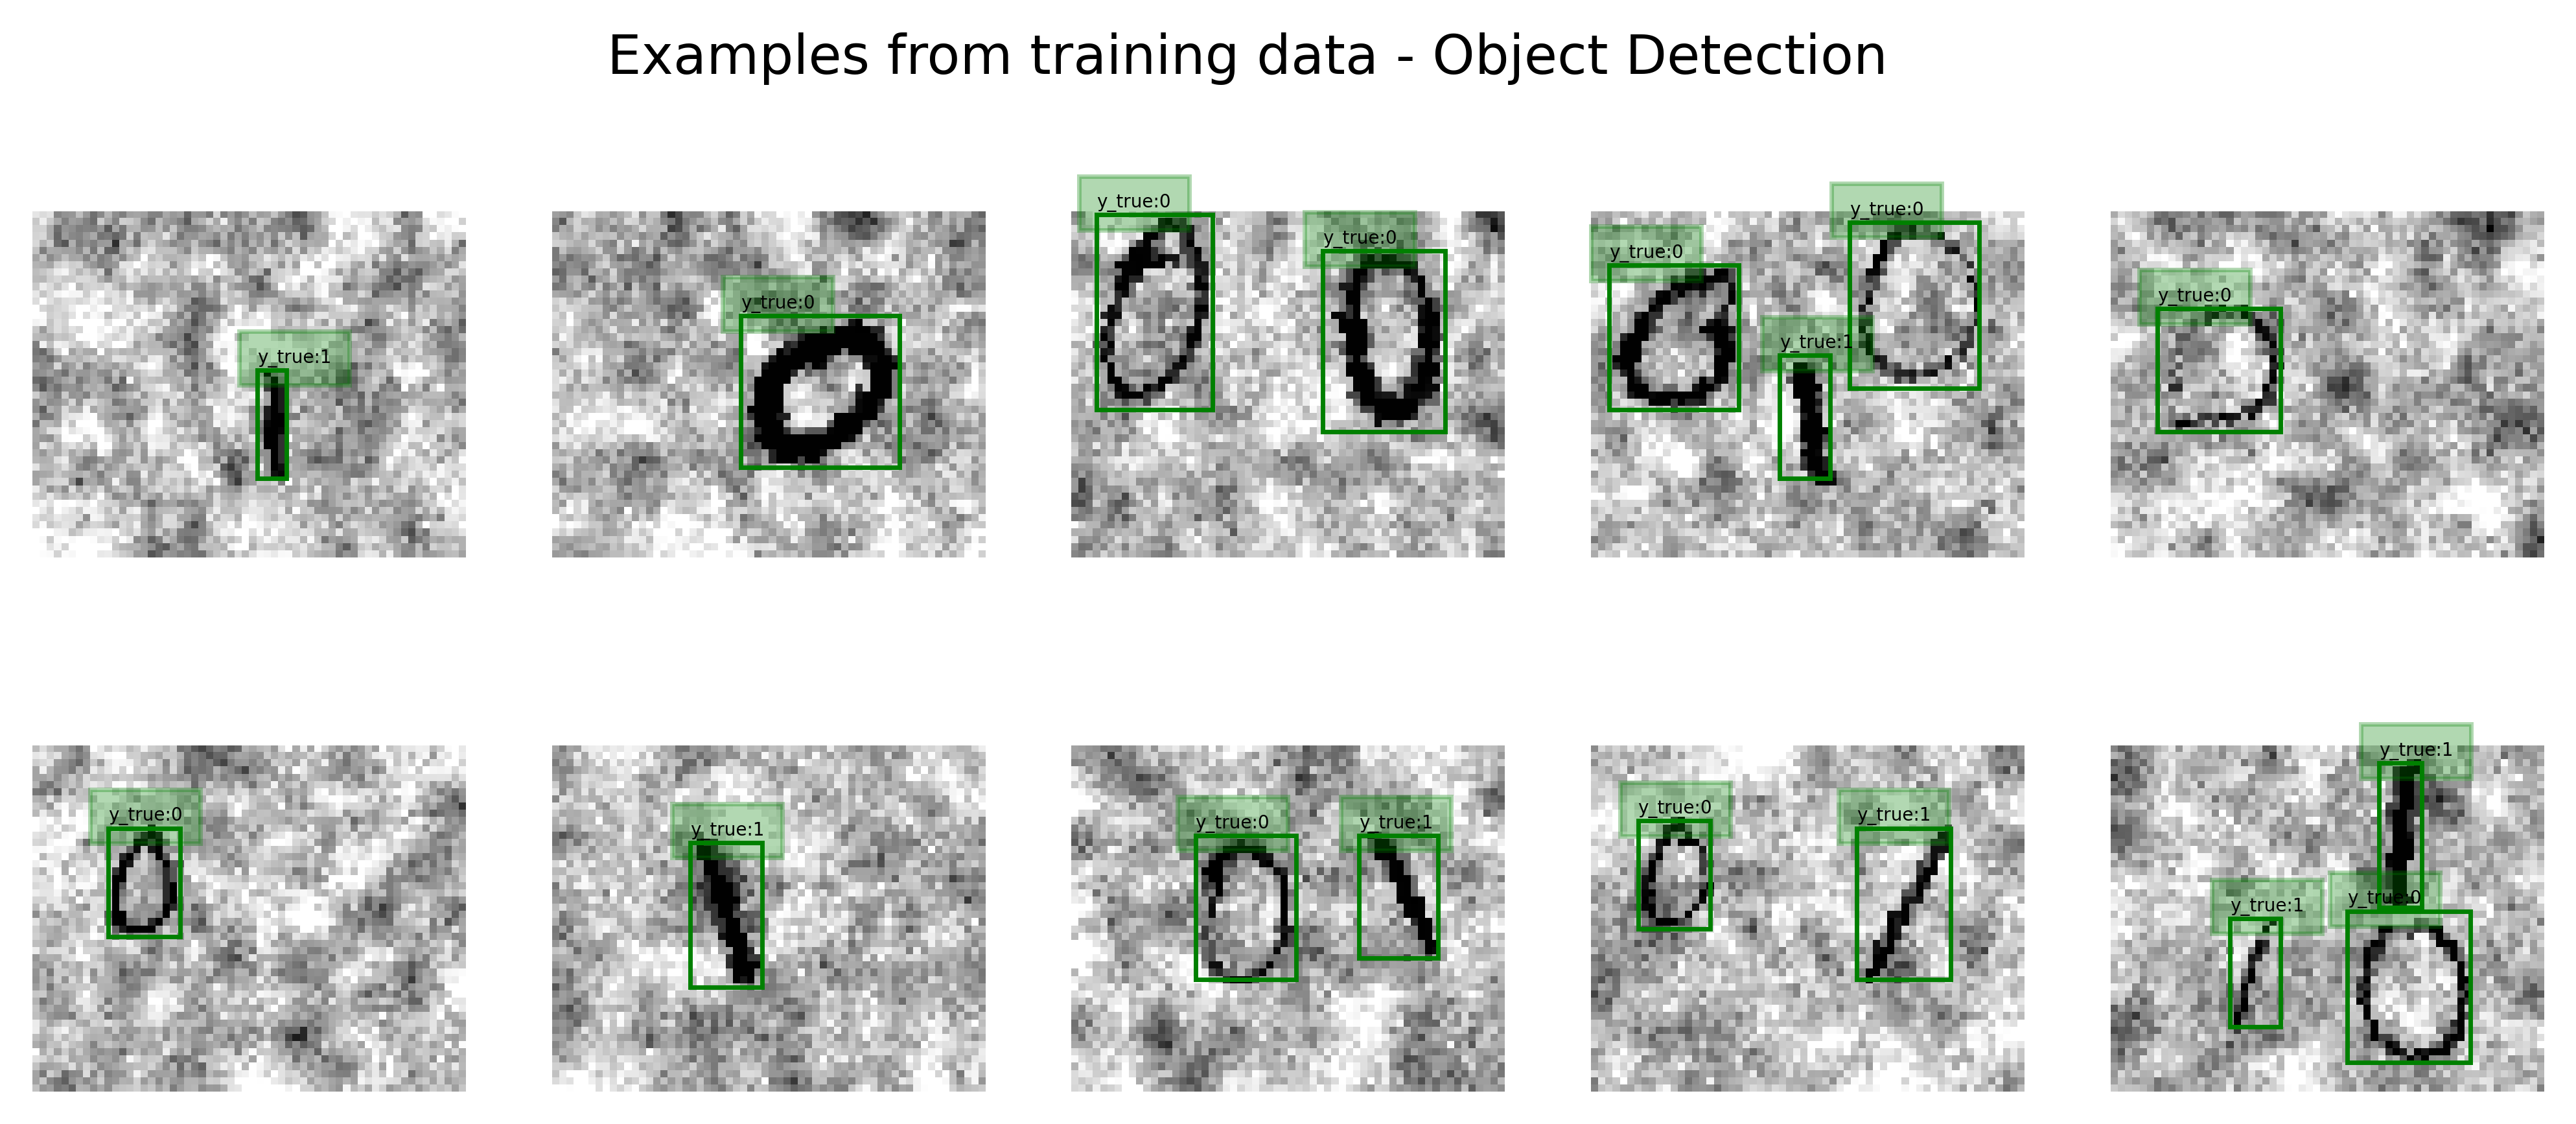

In [9]:
plot_detection_data(detection_train, "Examples from training data - Object Detection")

Next we want to implement a model such that the fully connected layers are replaced by convolutional layers and such that the last layer yields an output of the right dimension ((N, Hout, Wout, C + 5)
with N the batch size).

We first tried with AlexNet, which is similar to LeNet, but deeper, has more filters, stacked convolutional layers, max pooling and dropout.

In [10]:
output_layer = 7*3*2
dropout_rate = 0.5

# With inspiration from https://github.com/Lornatang/AlexNet-PyTorch/blob/master/alexnet_pytorch/model.py
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_layer),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out.double()

The object detection loss function Ldetection is the sum of the localization loss of each grid cell
The performance is similar to the localization performance applied to each grid cell

In [11]:
def detection_loss_fn(Y_pred, Y_true):
    total_loss = 0
    for h in range(0,len(Y_true[0])):
            for w in range(0,len(Y_true[0][0])-1):
                total_loss += loss_fn(Y_pred[h][w], Y_true[h][w])

    return total_loss

def detection_performance(Y_pred, Y_true):
    total_performance = 0
    total_iou = 0
    total_accuracy = 0
    for h in range(0,len(Y_true[0])):
            for w in range(0,len(Y_true[0][0])-1):
                p_list = performance(Y_pred[h][w], Y_true[h][w])

                total_performance += (p_list[0]/6)
                total_iou += (p_list[1]/6)
                total_accuracy += (p_list[2]/6)


    return [total_performance, total_iou, total_accuracy]
    

In [12]:
def train_detection_fn(n_epochs, optimizer, model, loss_fn, loader):
    steps = len(loader)

    model.train()

    losses = []
    scores = []

    with tqdm(total=steps) as pbar:
        for epoch in range(1, n_epochs + 1):
            pbar.set_description(f"epoch: {epoch}")
            loss_list = []
            score_list = []

            for imgs, Y_true in loader:
                pbar.update(1)

                imgs = imgs.to(device=device, dtype=torch.double)
                Y_true = Y_true.to(device=device)

                Y_pred = model(imgs)

                Y_pred = Y_pred.reshape([Y_pred.size()[0], 2, 3, 7])

                loss = loss_fn(Y_pred.float(), Y_true.float())
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                score = detection_performance(Y_pred, Y_true)
                score_list.append(score[0].item())
                loss_list.append(loss.item())

            scores.append(mean(score_list))
            losses.append(mean(loss_list))
            pbar.reset()

    return scores, losses


We did not see good results with AlexNet, and thought maybe that the model performed poorly because of number of epochs. We tried with 100 epochs which took 333 minutes. ![](./assets/AlexNet_detection.png)

In [108]:
batch_size = 64
lr = 0.001
epochs = 10

detection_train_loader = torch.utils.data.DataLoader(detection_train, batch_size=batch_size, shuffle=True)


alex_net = AlexNet().to(device)
optimizer = torch.optim.Adam(alex_net.parameters(), lr=lr)
score, losses = train_detection_fn(epochs, optimizer, alex_net, detection_loss_fn, detection_train_loader)

In [14]:
plot_training_data(score, losses, f"Performance and Training loss of AlexNet with lr:{lr} and batch_size:{batch_size}")

In [15]:
detection_val_loader = torch.utils.data.DataLoader(detection_val, batch_size=batch_size, shuffle=True)

alexnet_performance = check_performance(
    alex_net, [("training", detection_train_loader), ("validation", detection_val_loader)], detection_performance, detection = True
)


  0%|          | 0/108 [00:00<?, ?it/s]

Performance training data: 0.14
IOU training data: 0.00
Accuracy training data: 0.28


  0%|          | 0/13 [00:00<?, ?it/s]

Performance validation data: 0.14
IOU validation data: 0.00
Accuracy validation data: 0.29


Next we tried MyModel, adjusted for the new output size

In [16]:
output_layer = 7*3*2

class MyModelDetection(nn.Module):
    def __init__(self):
        super(MyModelDetection, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1728, out_features=900),
            nn.ReLU(),
            nn.Linear(in_features=900, out_features=400),
            nn.ReLU(),
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=output_layer),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out.double()

In [17]:
batch_size = 128
lr = 0.005
epochs = 20

detection_train_loader = torch.utils.data.DataLoader(detection_train, batch_size=batch_size, shuffle=True)


my_detection_model = MyModelDetection().to(device)
optimizer = torch.optim.Adam(my_detection_model.parameters(), lr=lr)

score, losses = train_detection_fn(epochs, optimizer, my_detection_model, detection_loss_fn, detection_train_loader)

  0%|          | 0/54 [00:00<?, ?it/s]

In [18]:
plot_training_data(score, losses, f"Performance and Training loss of MyModel with lr:{lr} and batch_size:{batch_size}")

In [19]:
detection_val_loader = torch.utils.data.DataLoader(detection_val, batch_size=batch_size, shuffle=True)


my_model_performance = check_performance(
    my_detection_model, [("training", detection_train_loader), ("validation", detection_val_loader)], detection_performance, detection = True
)


  0%|          | 0/54 [00:00<?, ?it/s]

Performance training data: 0.15
IOU training data: 0.03
Accuracy training data: 0.27


  0%|          | 0/7 [00:00<?, ?it/s]

Performance validation data: 0.16
IOU validation data: 0.03
Accuracy validation data: 0.29


We did not see particualry good results with M

In [62]:
def visualize_detection_pred(model, loader, title):
    COL = 5
    ROW = 1
    fig = plt.figure(figsize=(10, 2), dpi=500)

    for index in range(1, COL * ROW + 1):
        plt.subplot(ROW, COL, index)
        plt.axis("off")

        batch = next(iter(loader))

        imgs, Y_true = batch

        imgs = imgs.to(device=device, dtype=torch.double)
        Y_pred = model(imgs)
        Y_pred = Y_pred.reshape([Y_pred.size()[0], 2, 3, 7])

        imgs = imgs.cpu()
        Y_pred = Y_pred.cpu()

        
        y_pred_i = Y_pred[index]


        # Converting continous pc and the 2 class labels to single digits
        y_pred_i[:, :, 0] = (Sigmoid(y_pred_i[:, :, 0]) > 0.5).float()

        y_pred_i_convert = []
        for i in y_pred_i:
            y_i_list_convert= []
            for j in i:
                if j.data[5] < j.data[6]:
                    pc = torch.Tensor([float(1)])
                else:
                    pc = torch.Tensor([float(0)])
                y_i_convert = torch.cat((j.data[0:5],pc), 0)
                y_i_list_convert.append(y_i_convert)
            y_pred_i_convert.append(y_i_list_convert)


        

        plt.imshow(imgs[index][0], cmap="gray_r")

        for h, list_y_true in enumerate(Y_true[index]):
            for w, y_true in enumerate(list_y_true):
                if y_true[0] == 1:
                    draw_x, draw_y, draw_w, draw_h = detection_to_lower_xy(y_true, h, w)
                    rect = Rectangle(
                        (draw_x, draw_y),
                        draw_w,
                        draw_h,
                        linewidth=1,
                        edgecolor="g",
                        facecolor="none",
                    )
                    ax = plt.gca()
                    ax.add_patch(rect)
                    t = plt.text(
                        draw_x, draw_y - 1, f"y_true:{int(y_true[5])}", fontsize=4
                    )
                    t.set_bbox(dict(facecolor="green", alpha=0.3, edgecolor="green"))

        for h, list_y_pred in enumerate(y_pred_i_convert):
            for w, y_pred in enumerate(list_y_pred):
                if y_pred[0] == 1:
                    draw_x, draw_y, draw_w, draw_h = detection_to_lower_xy(y_pred, h, w)
                    rect = Rectangle(
                        (draw_x, draw_y),
                        draw_w,
                        draw_h,
                        linewidth=1,
                        edgecolor="m",
                        facecolor="none",
                    )
                    ax = plt.gca()
                    ax.add_patch(rect)
                    t = plt.text(
                        draw_x, draw_y - 1, f"y_pred:{int(y_pred[5])}", fontsize=4
                    )
                    t.set_bbox(dict(facecolor="m", alpha=0.3, edgecolor="m"))
    fig.suptitle(title)



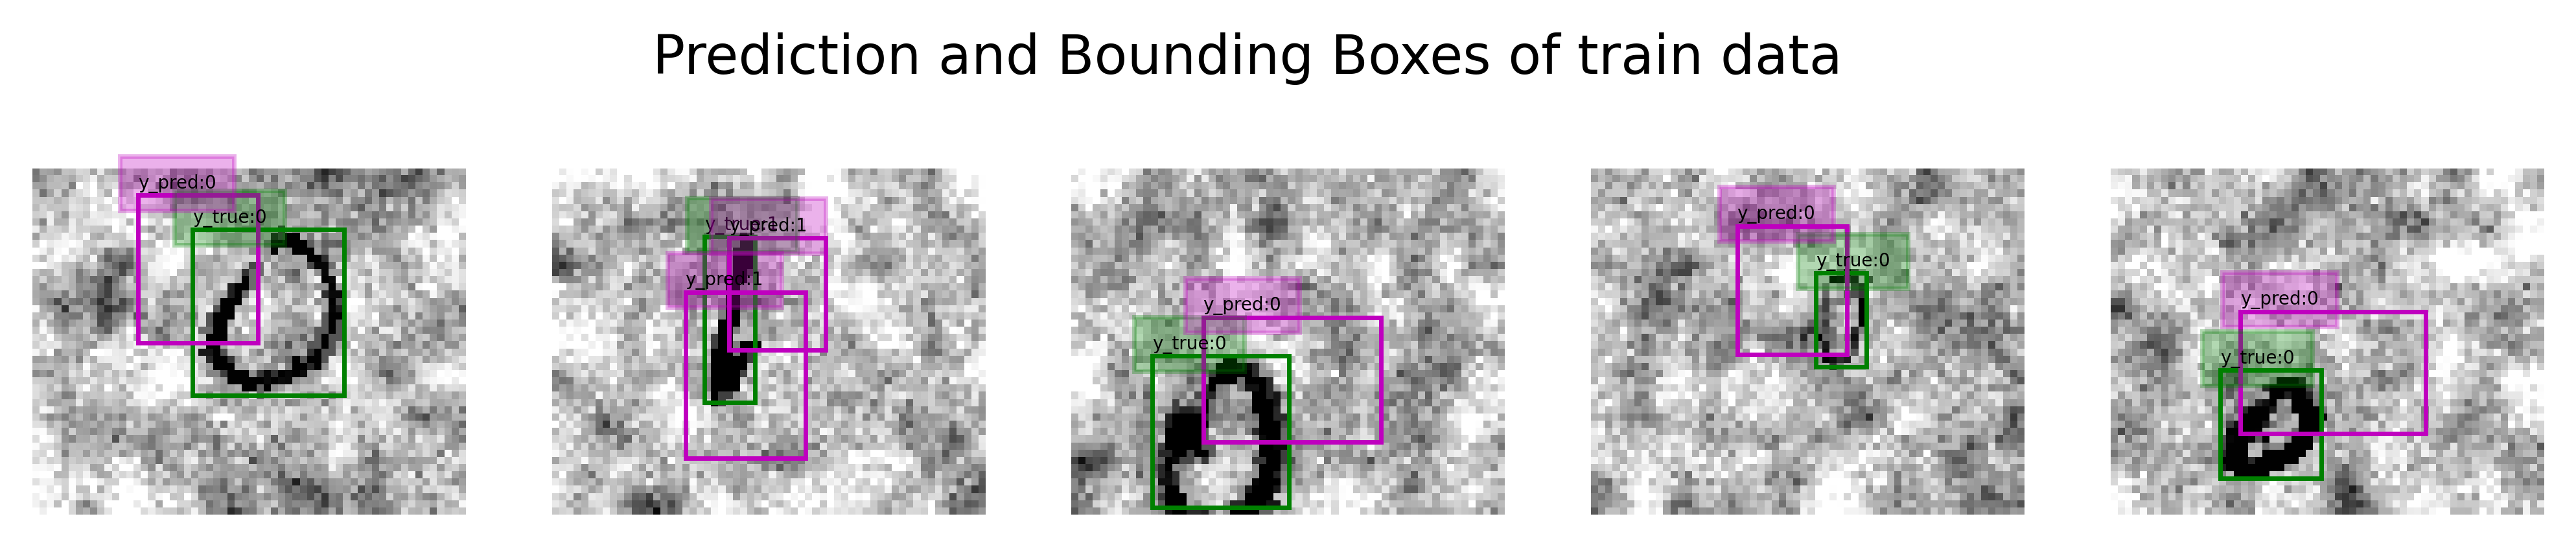

In [77]:
visualize_detection_pred(my_detection_model, detection_train_loader, "Prediction and Bounding Boxes of train data")

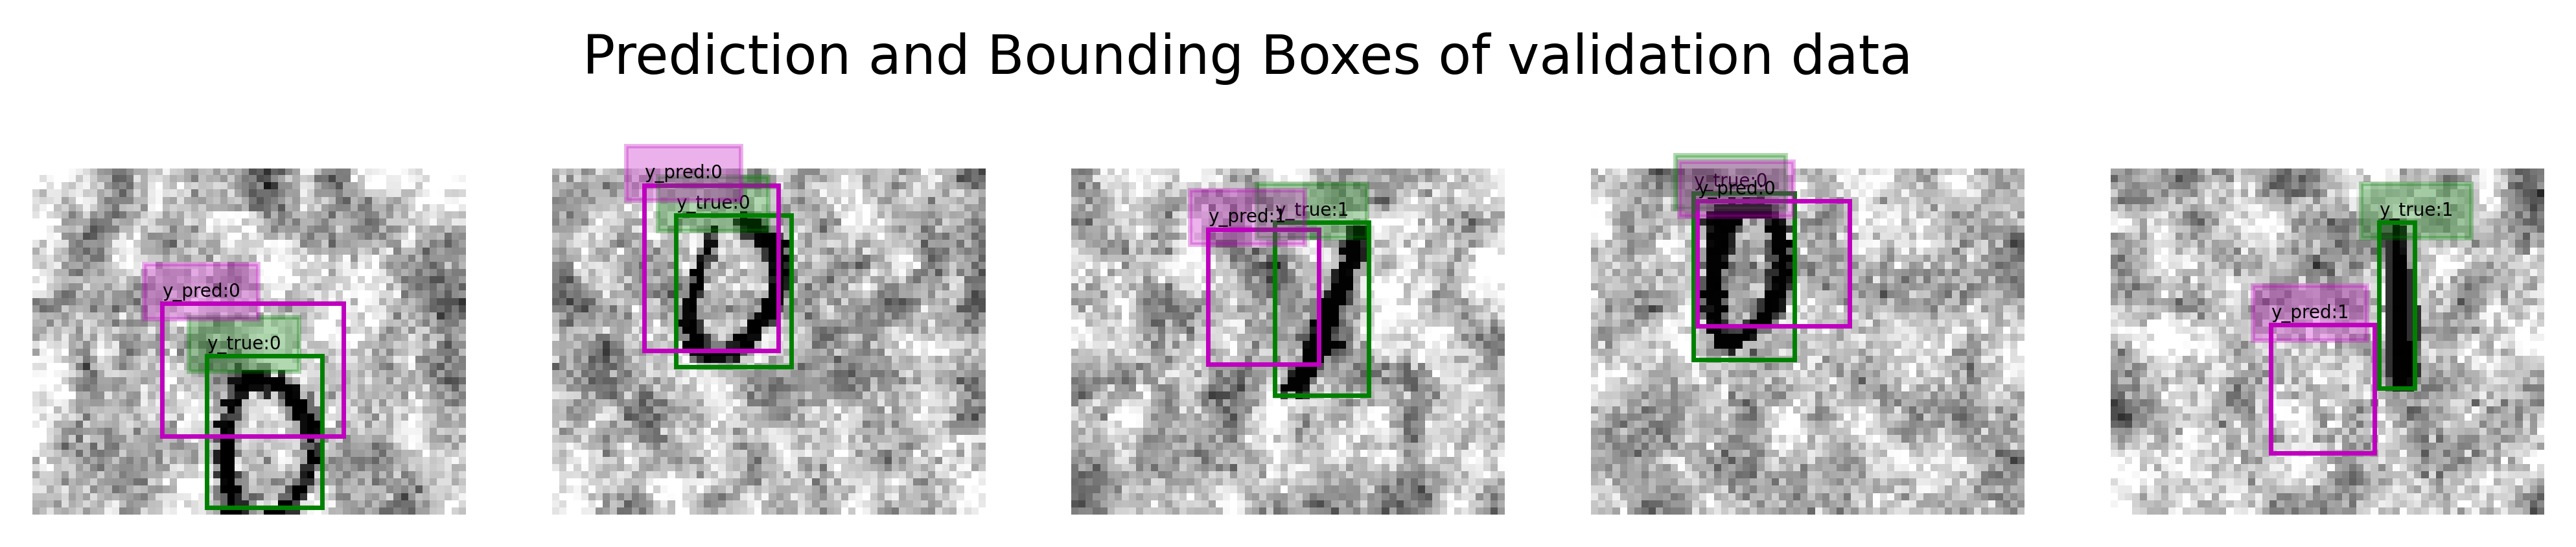

In [73]:
visualize_detection_pred(my_detection_model, detection_val_loader, "Prediction and Bounding Boxes of validation data")

Since MyModelDetection is the only model we got working we will select this model and evaluate performance on test data. But it seems bad at recognizing several digits, and usually predicts a single digit.

In [23]:
detection_test_loader = torch.utils.data.DataLoader(detection_test, batch_size=batch_size, shuffle=True)


my_model_performance = check_performance(
    my_detection_model, [("test", detection_test_loader)], detection_performance, detection = True
)

  0%|          | 0/10 [00:00<?, ?it/s]

Performance test data: 0.17
IOU test data: 0.04
Accuracy test data: 0.29


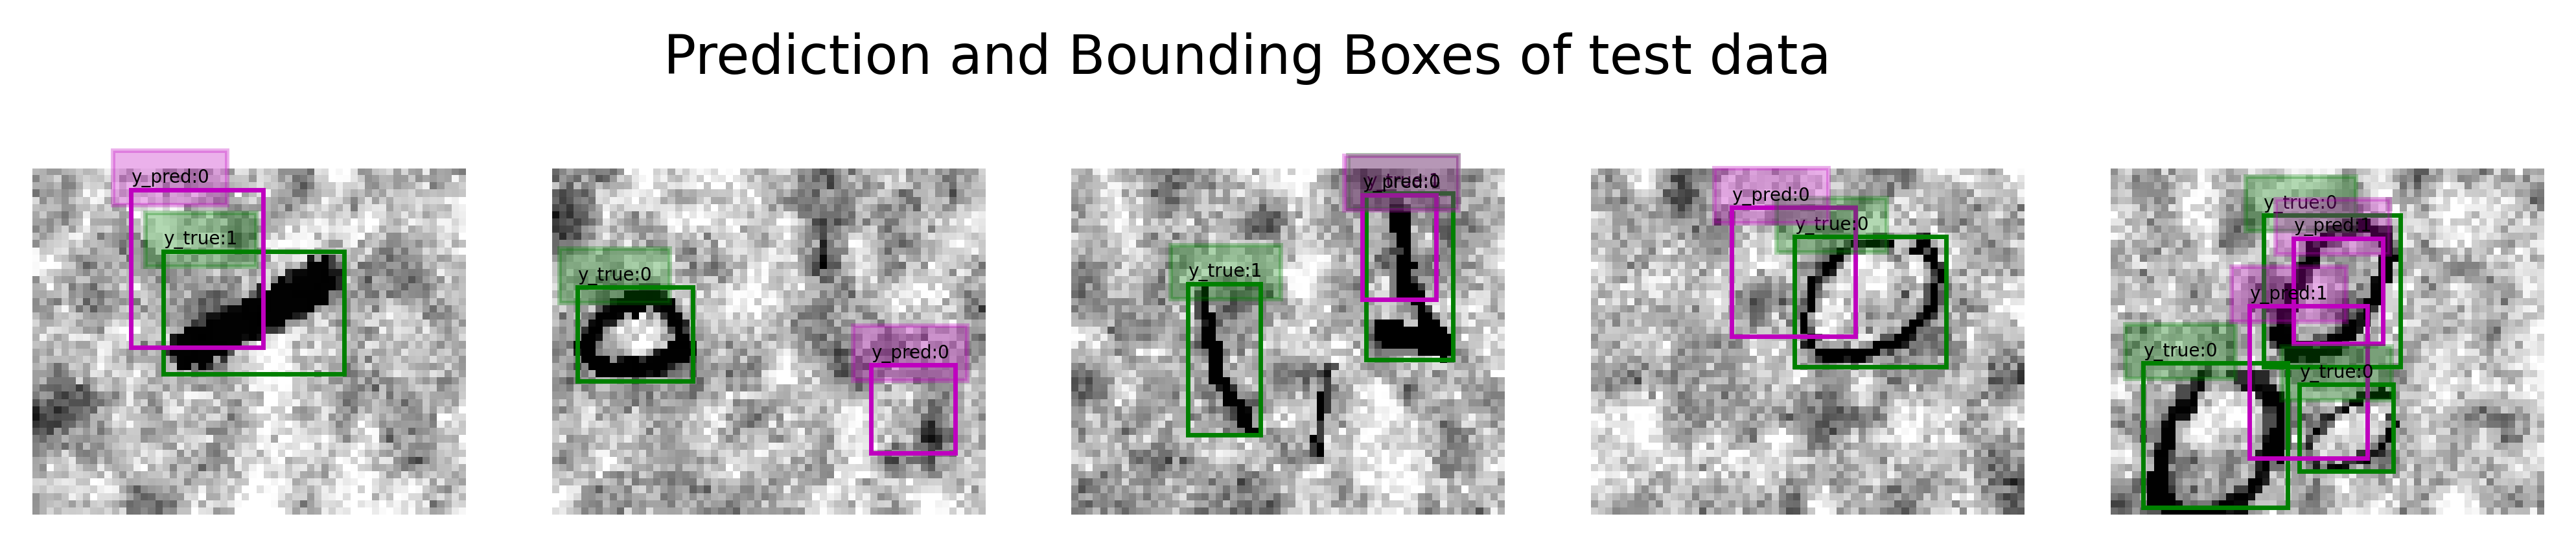

In [79]:
visualize_detection_pred(my_detection_model, detection_test_loader, "Prediction and Bounding Boxes of test data")